# Traffic jam exploration
* From the heatmap perspective

In [ ]:
%matplotlib inline
import pandas as pd
import gzip
import time
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as datetime
import matplotlib.dates as mdates
from dateutil import parser
import calendar

from skimage import measure
from skimage.filters import roberts, sobel, scharr, prewitt
from pandas import rolling_median
import time
from bkheatmap import bkheatmap
from scipy import ndimage as ndi

from skimage import feature

import charts

import pickle

from math import pi



from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper
from bokeh.plotting import figure
output_notebook() 




In [2]:
file_content = pd.read_csv("../five_min_frame.zip")

In [3]:
file_content.shape

(154289957, 13)

In [4]:
pd.to_datetime('01/01/2015 00:00:00',format='%m/%d/%Y %H:%M:%S')

Timestamp('2015-01-01 00:00:00')

In [5]:
file_content.head(1)

,Unnamed: 0,Timestamp,Station,District,Freeway #,Direction,Lane Type,Station Length,Samples,% Observed,Total Flow,Avg Occupancy,Avg Speed
0,0,01/01/2015 00:00:00,1100313,11,5,N,FR,NaN,10,100,16.0,NaN,NaN


In [6]:
meta = pickle.load(open("test.pk",'r'))

In [7]:
meta  = meta.reset_index()

In [8]:
meta['Station']=meta['ID']

In [9]:
meta.head(1)

,index,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,...,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,file_date,Station
0,0,1114091,5,N,11,73,66000.0,R.147,0.057,32.542842,...,0.6,ML,6,N/O CMNO DE LA PLAZA,3001,NaN,NaN,NaN,12_17,1114091


In [10]:
meta.head(1)

,index,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,...,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,file_date,Station
0,0,1114091,5,N,11,73,66000.0,R.147,0.057,32.542842,...,0.6,ML,6,N/O CMNO DE LA PLAZA,3001,NaN,NaN,NaN,12_17,1114091


In [11]:
#filter freeway to I5 Northbound
df = file_content[(file_content['Freeway #'] == 5) & (file_content['Direction'] == 'N')]

#convert Timestate to pd.datetime
df.loc[:,'Timestamp'] = pd.to_datetime(df.loc[:,'Timestamp'], format='%m/%d/%Y %H:%M:%S')

df = pd.merge(df, meta.loc[:,['Station','index']], on='Station', how='outer')

df=df[df['Lane Type']=='ML']

/Users/multidest/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [12]:
df.head(3)

,Unnamed: 0,Timestamp,Station,District,Freeway #,Direction,Lane Type,Station Length,Samples,% Observed,Total Flow,Avg Occupancy,Avg Speed,index
733523,219,2015-01-01 00:00:00,1108437,11,5,N,ML,0.219,40,100,55.0,0.0104,67.2,95
733524,1698,2015-01-01 00:05:00,1108437,11,5,N,ML,0.219,40,100,44.0,0.0089,67.7,95
733525,3177,2015-01-01 00:10:00,1108437,11,5,N,ML,0.219,4,100,20.0,0.0034,69.3,95


In [13]:
#Slice df from start to end date and pivot on Station, Timestamp and $on
def get_timeslice(df, start_date, end_date, on='Avg Speed'):
    
    start = pd.to_datetime(start_date + " 00:00:01", format = '%m/%d/%Y %H:%M:%S')
    end = pd.to_datetime(end_date + " 23:59:00", format = '%m/%d/%Y %H:%M:%S')
    freeway = df[(df['Timestamp'] > start) & (df['Timestamp'] <= end)]
    
    freeway = freeway.sort_values(['index','Timestamp'], axis=0, ascending=False)
        
    data = freeway.pivot(index='index', columns='Timestamp', values=on)
    
    
    return data

In [14]:
r = get_timeslice(df,start_date='03/10/2015', end_date='03/10/2015', on='Avg Speed')#.dropna(axis=0, how='all')
data = r.unstack().reset_index().rename(columns = {0:'value'})
data['color']=data['value'].apply(lambda x: '#75968f' if x > 60 else "#cc7878")
data['Timestamp']=data['Timestamp'].apply(lambda x: x.strftime(("%A %d %b %I:%M%p")))
data['index']=data['index'].apply(str)

In [15]:
data.head()

,Timestamp,index,value,color
0,Tuesday 10 Mar 12:05AM,0,66.2,#75968f
1,Tuesday 10 Mar 12:05AM,1,66.9,#75968f
2,Tuesday 10 Mar 12:05AM,2,69.1,#75968f
3,Tuesday 10 Mar 12:05AM,3,67.7,#75968f
4,Tuesday 10 Mar 12:05AM,4,70.4,#75968f


In [16]:
#draw heatmap of data
def plot_traffic_heat(data, cmap='magma'):
    
    f, ax = plt.subplots(figsize=(12, 12))

    sns.heatmap(data, ax=ax, square=False, xticklabels=12*12, cbar=False, cmap=cmap)#, center = 65)

    for item in ax.get_yticklabels():
        item.set_rotation(0)
        
    a=ax.get_xticklabels()
    a = [parser.parse(x.get_text()) for x in a]
    a = ["{}".format( x.strftime("%A %d %b %I:%M%p")) for x in a]

    ax.set_xticklabels(a)    
    

    ax.xaxis.grid(True)   
        
    #for item in ax.get_xticklabels():
    #    item.set_rotation(90)

    f.tight_layout()
    
    return (f, ax)
    

(<matplotlib.figure.Figure at 0x169eb0cd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10608ba90>)

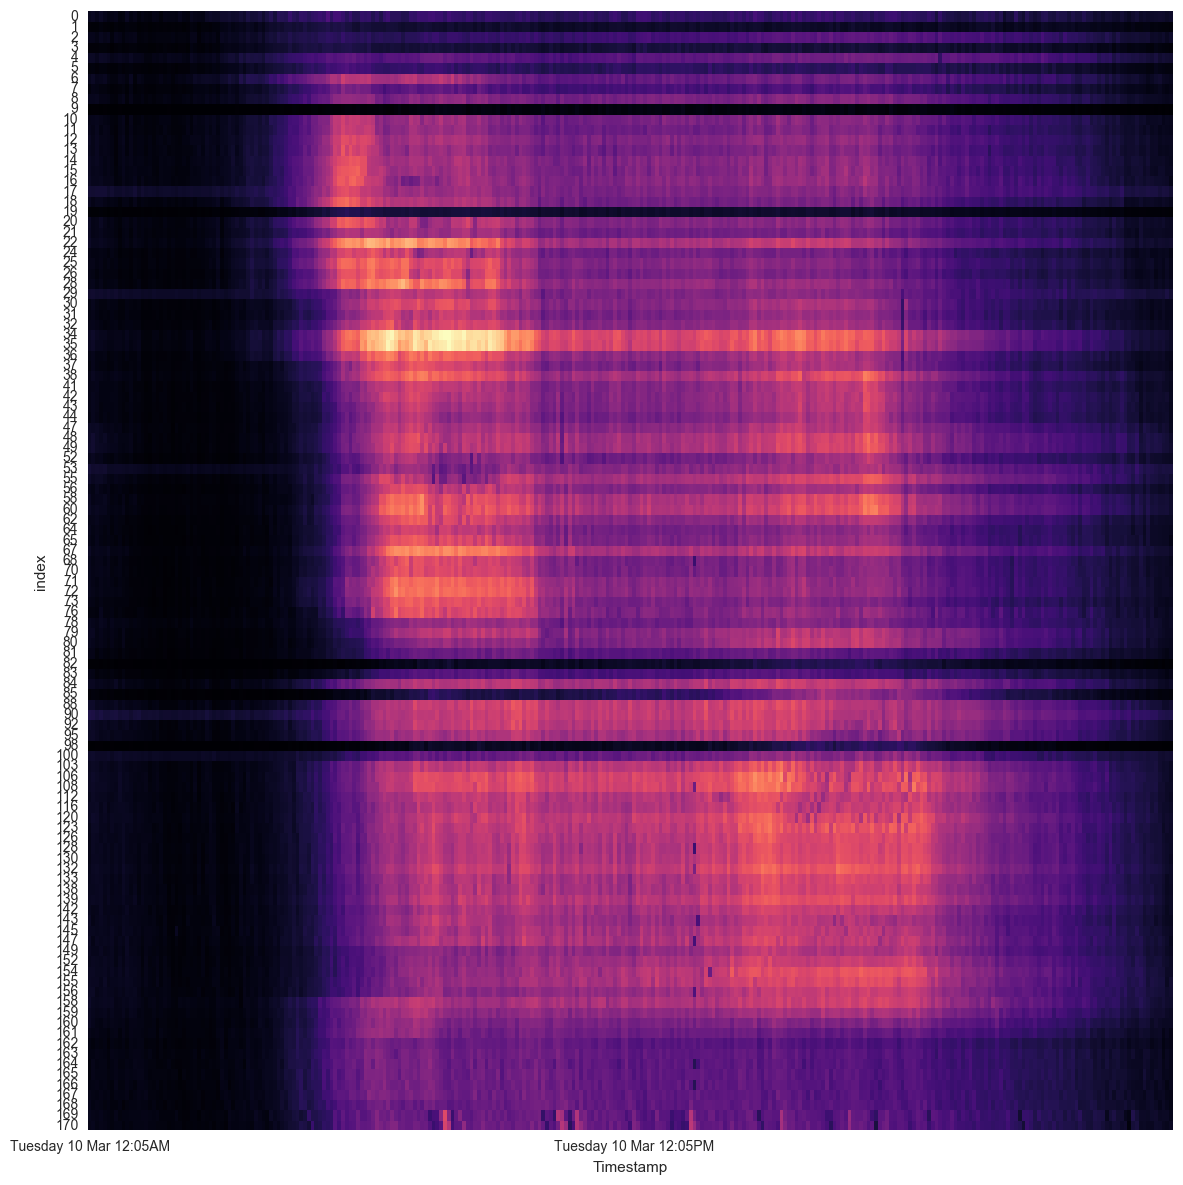

In [17]:
r = get_timeslice(df,start_date='03/10/2015', end_date='03/10/2015', on='Total Flow')#.dropna(axis=0, how='all')
plot_traffic_heat(r)

(<matplotlib.figure.Figure at 0x11bcca790>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11bcb5a10>)

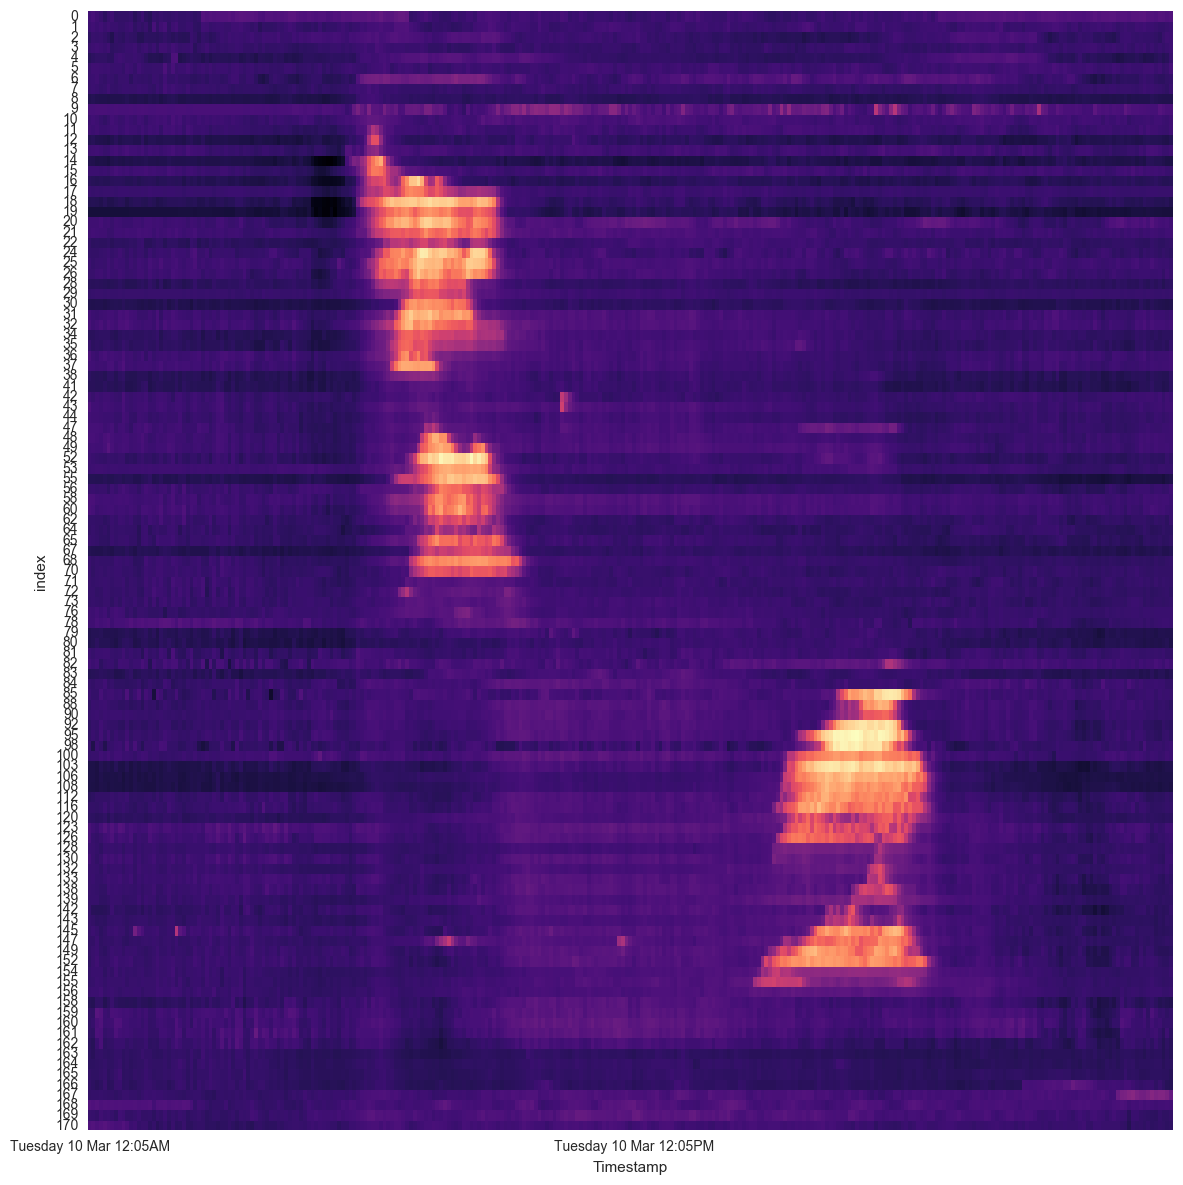

In [18]:
r = get_timeslice(df,start_date='03/10/2015', end_date='03/10/2015', on='Avg Speed')#.dropna(axis=0, how='all')
plot_traffic_heat(r, cmap='magma_r')

(<matplotlib.figure.Figure at 0x11ada3850>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11bbd8dd0>)

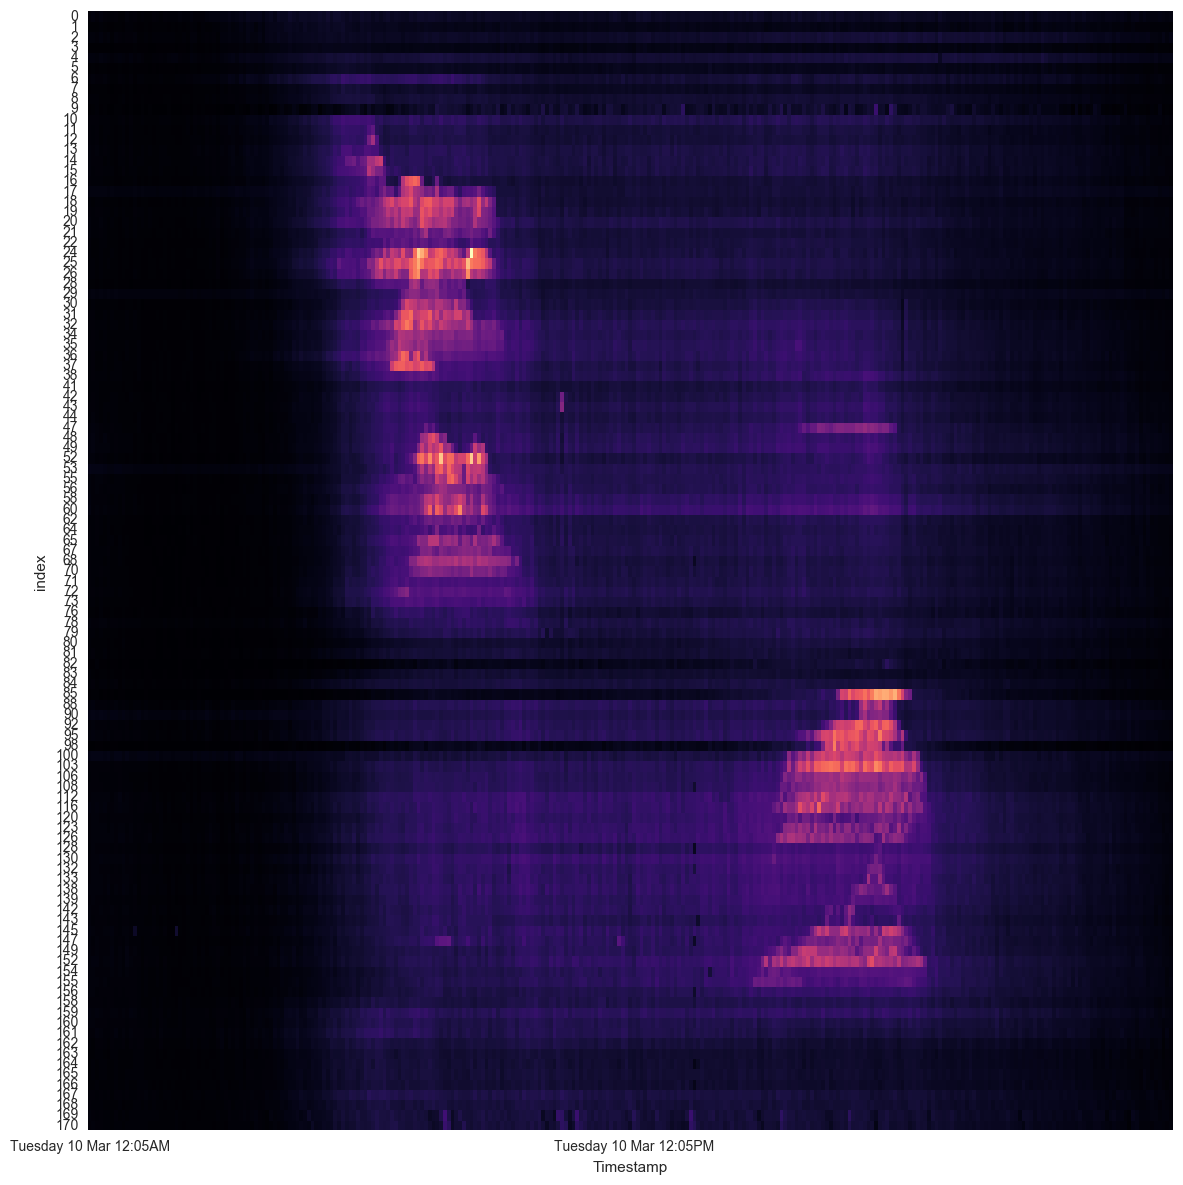

In [19]:
r = get_timeslice(df,start_date='03/10/2015', end_date='03/10/2015', on='Avg Occupancy')#.dropna(axis=0, how='all')
plot_traffic_heat(r)

In [20]:
def plot_contours(r, threshold, cmap='magma',title=""):  
    f, ax = plot_traffic_heat(r, cmap=cmap)
    
    ax.set_title(title)
    
    r = r.rolling(window=6,center=True).median()
    contours = measure.find_contours(r[::-1], threshold, fully_connected='high')
    
    for n, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color = '#33f725')

    f.tight_layout()

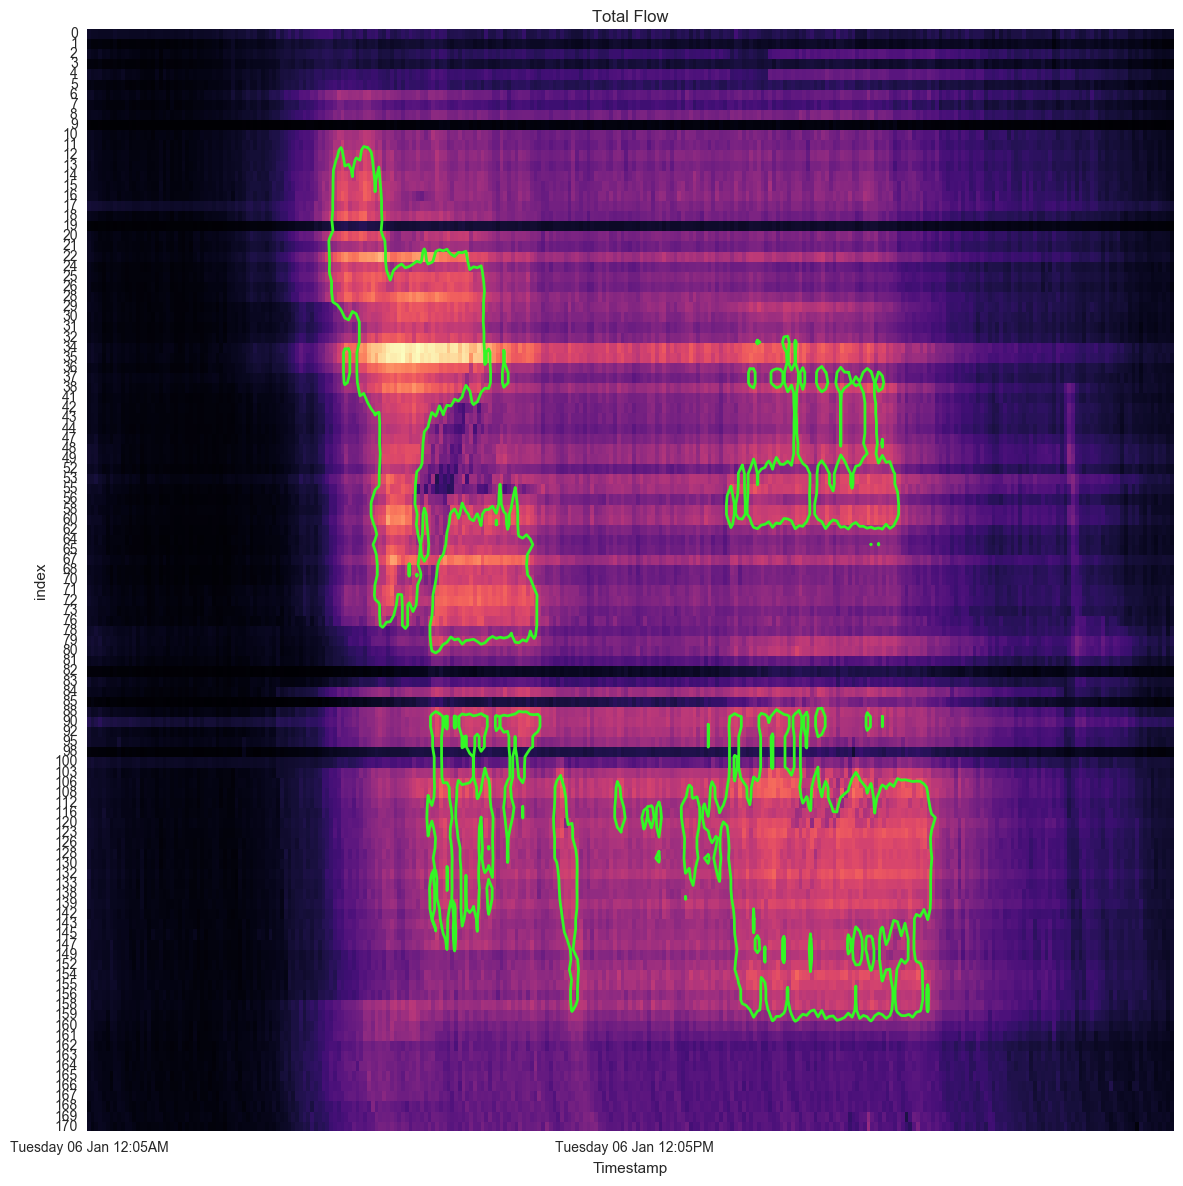

In [21]:
r = get_timeslice(df,start_date='01/6/2015', end_date='01/6/2015', on='Total Flow')#.dropna(axis=0, how='all')
plot_contours(r, 500, title="Total Flow")

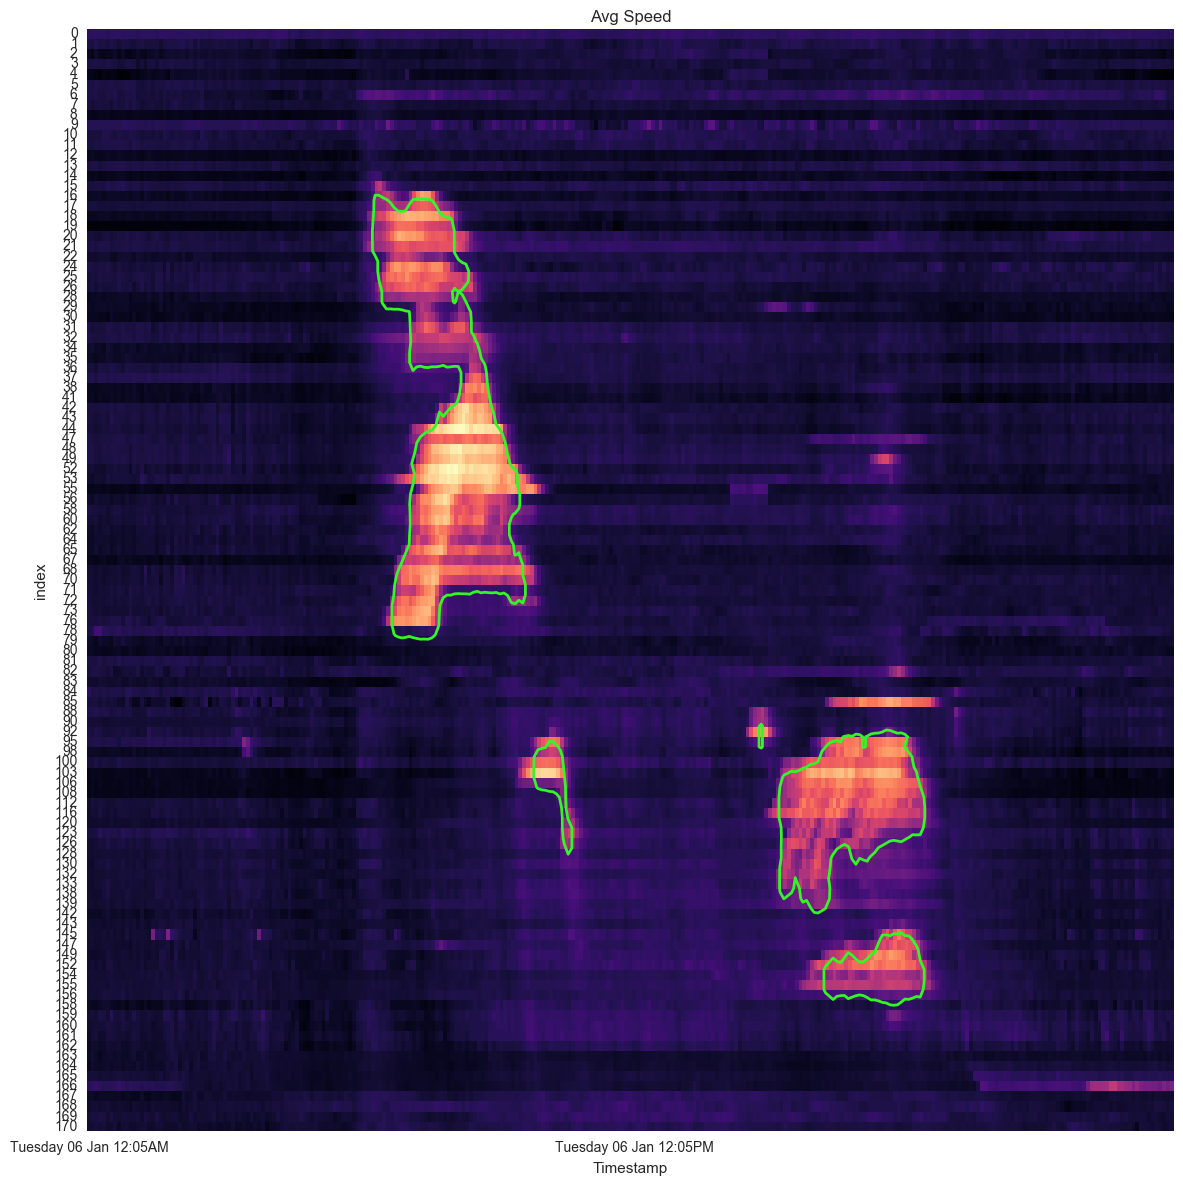

In [22]:
r = get_timeslice(df,start_date='01/6/2015', end_date='01/6/2015', on='Avg Speed')#.dropna(axis=0, how='all')
plot_contours(r, 50, cmap='magma_r', title="Avg Speed")

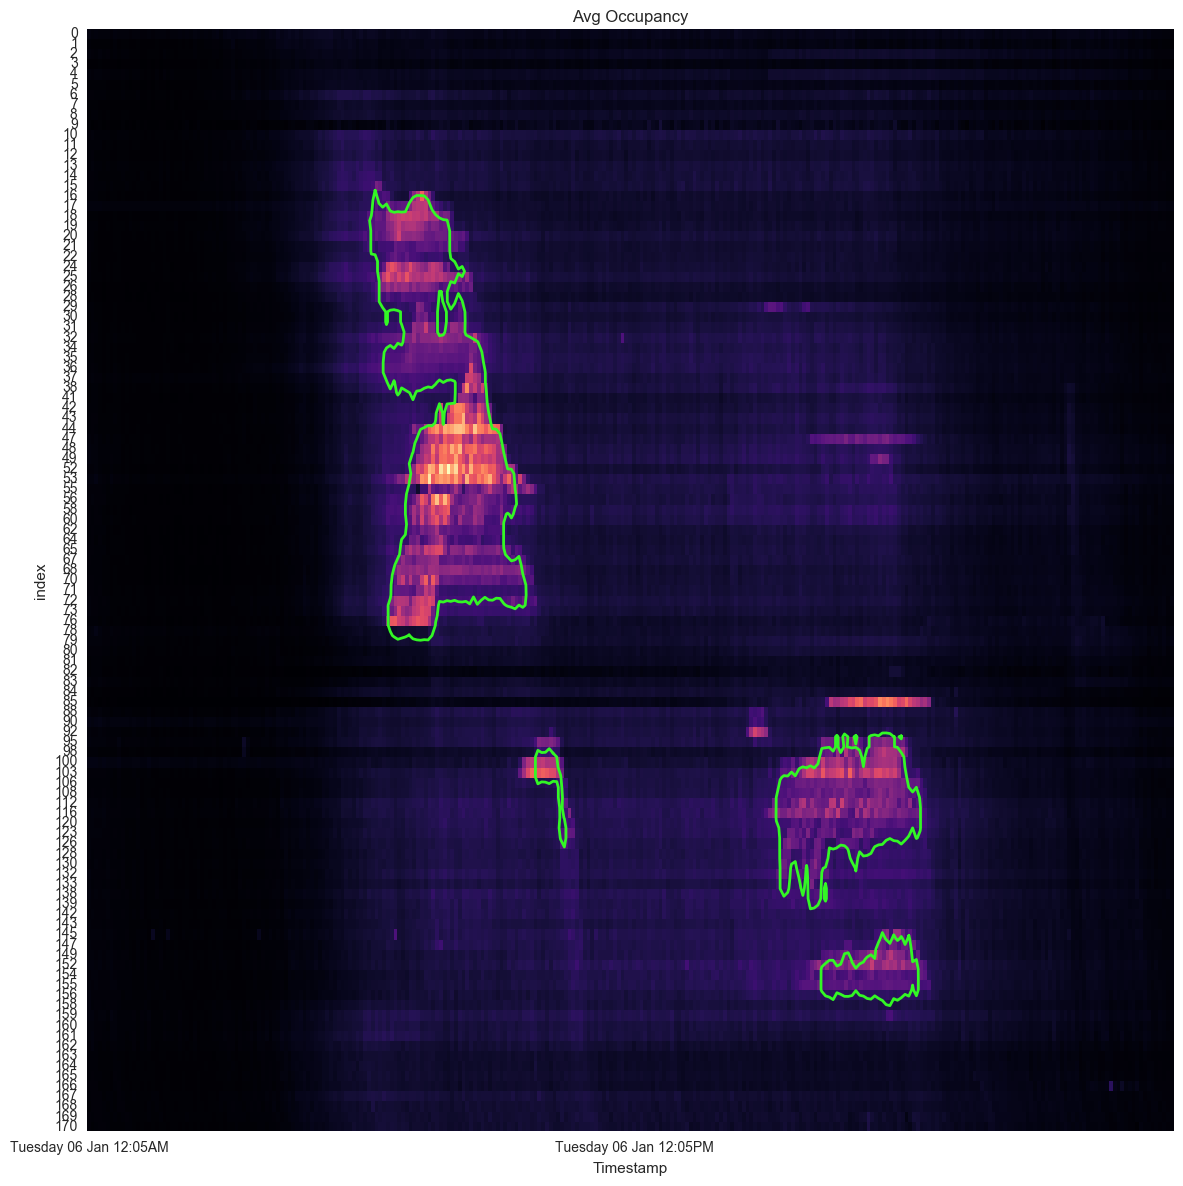

In [23]:
r = get_timeslice(df,start_date='01/6/2015', end_date='01/6/2015', on='Avg Occupancy')#.dropna(axis=0, how='all')
plot_contours(r,0.16, title="Avg Occupancy")

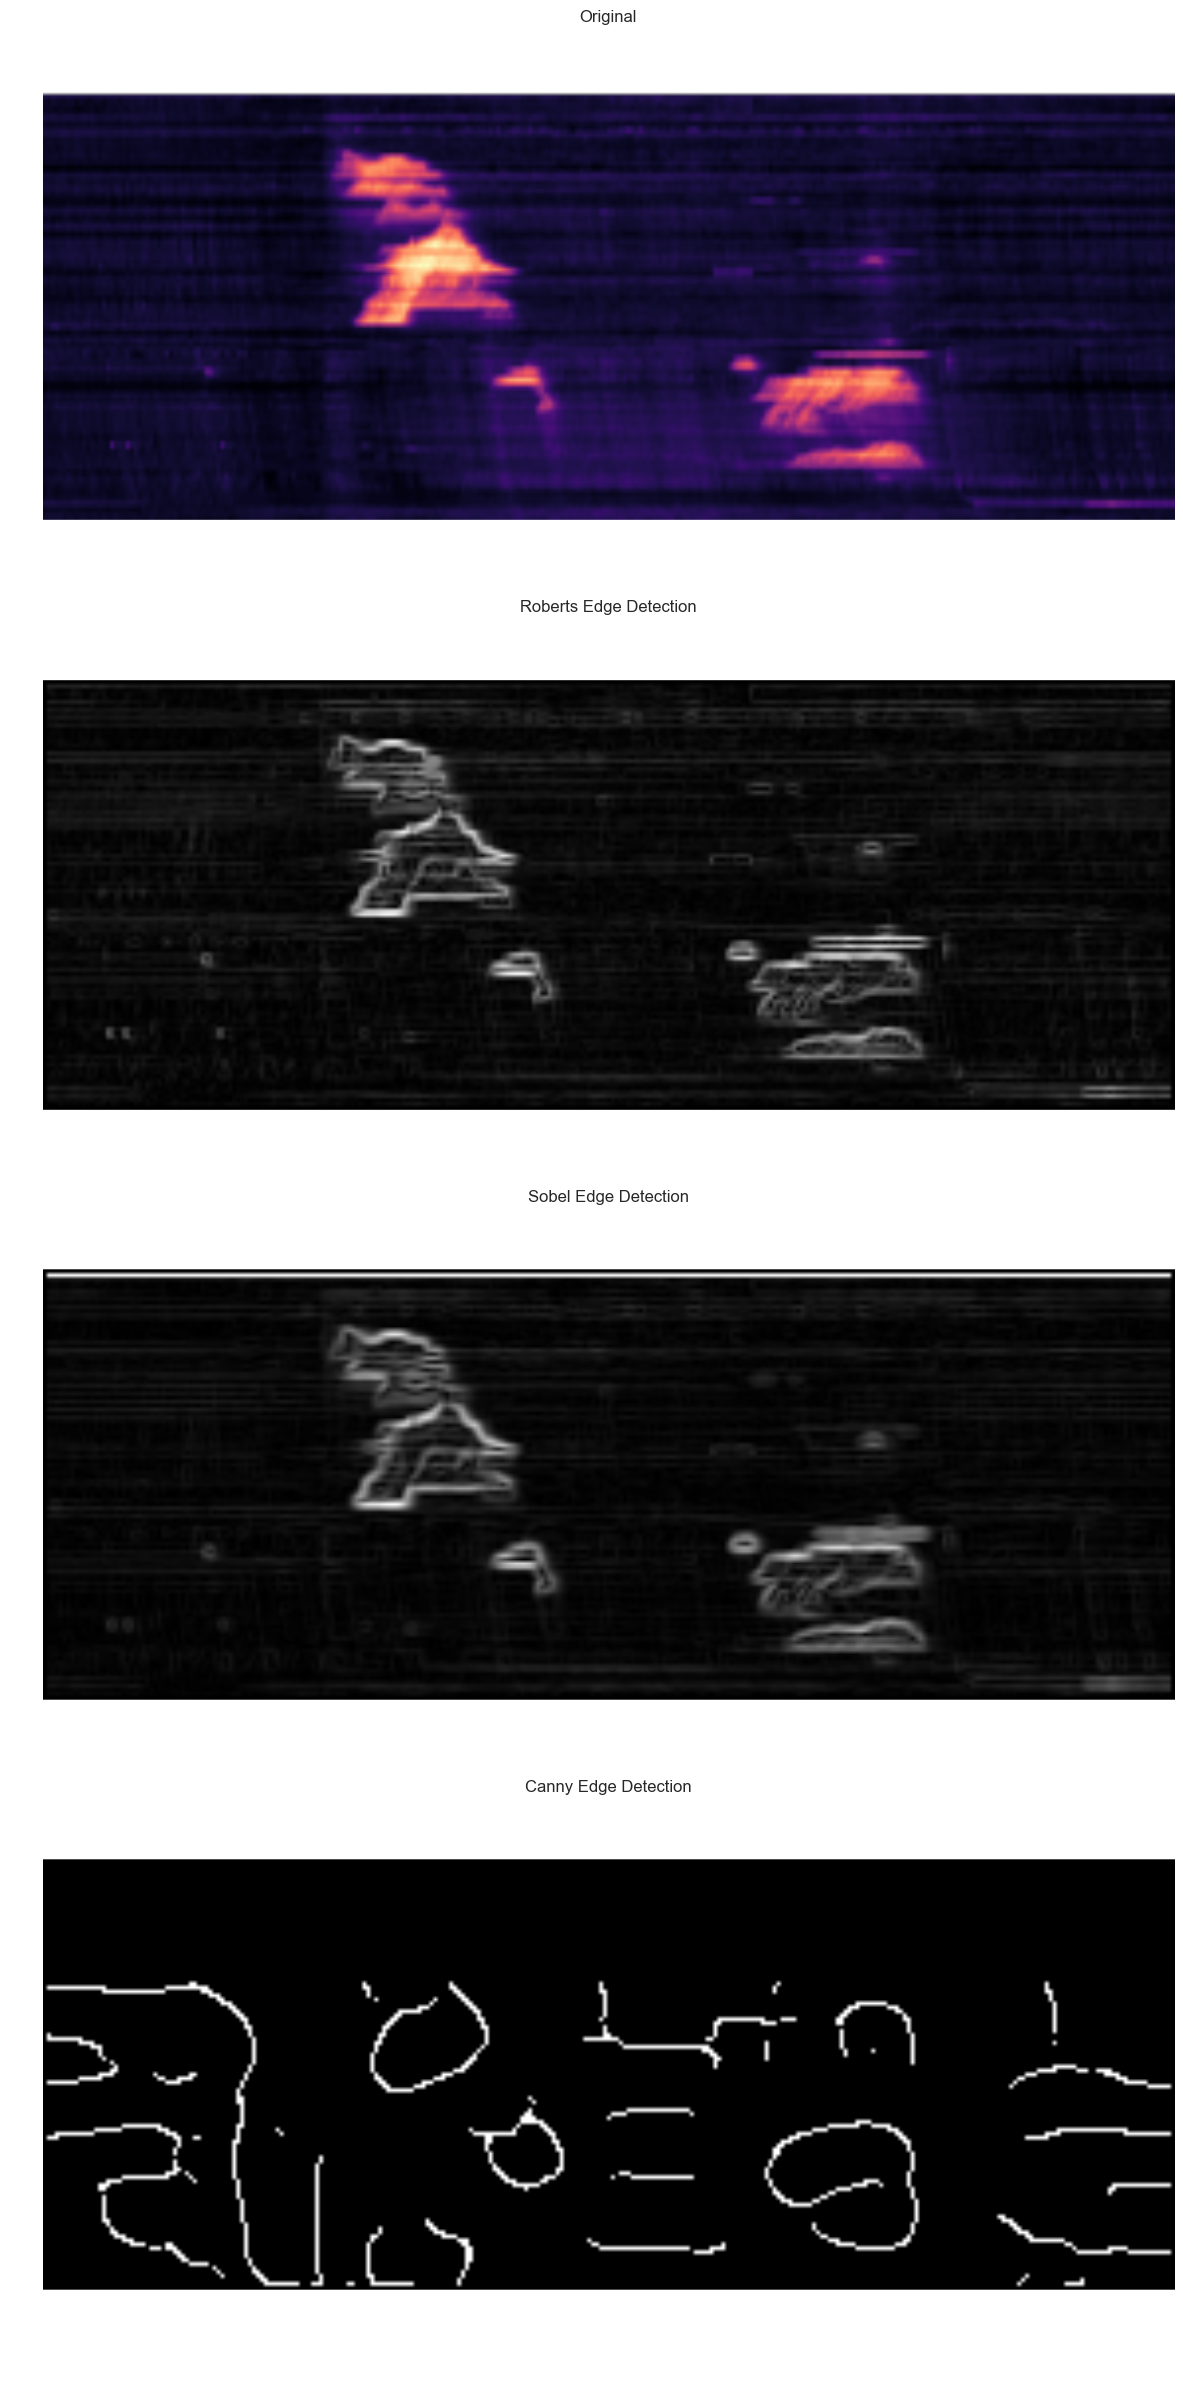

In [24]:
def plot_roberts_sobel(image):
    edge_roberts = roberts(image)
    edge_sobel = sobel(image)
    edge_canny = feature.canny(image.values, sigma=7)

    fig, ax = plt.subplots(nrows=4, sharex=True, sharey=True,
                           figsize=(12, 24))

    ax[0].imshow(image, cmap='magma_r')
    ax[0].set_title('Original')

    ax[1].imshow(edge_roberts, cmap=plt.cm.gray)
    ax[1].set_title('Roberts Edge Detection')

    ax[2].imshow(edge_sobel, cmap=plt.cm.gray)
    ax[2].set_title('Sobel Edge Detection')
    
    ax[3].imshow(edge_canny, cmap=plt.cm.gray)
    ax[3].set_title('Canny Edge Detection')

    for a in ax:
        a.axis('off')

    plt.tight_layout()
    plt.show()
    
r = get_timeslice(df,start_date='01/6/2015', end_date='01/6/2015', on='Avg Speed')
r = r.rolling(window=2,center=True).median()
plot_roberts_sobel(r)

(<matplotlib.figure.Figure at 0x11c9ffdd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11ad36610>)

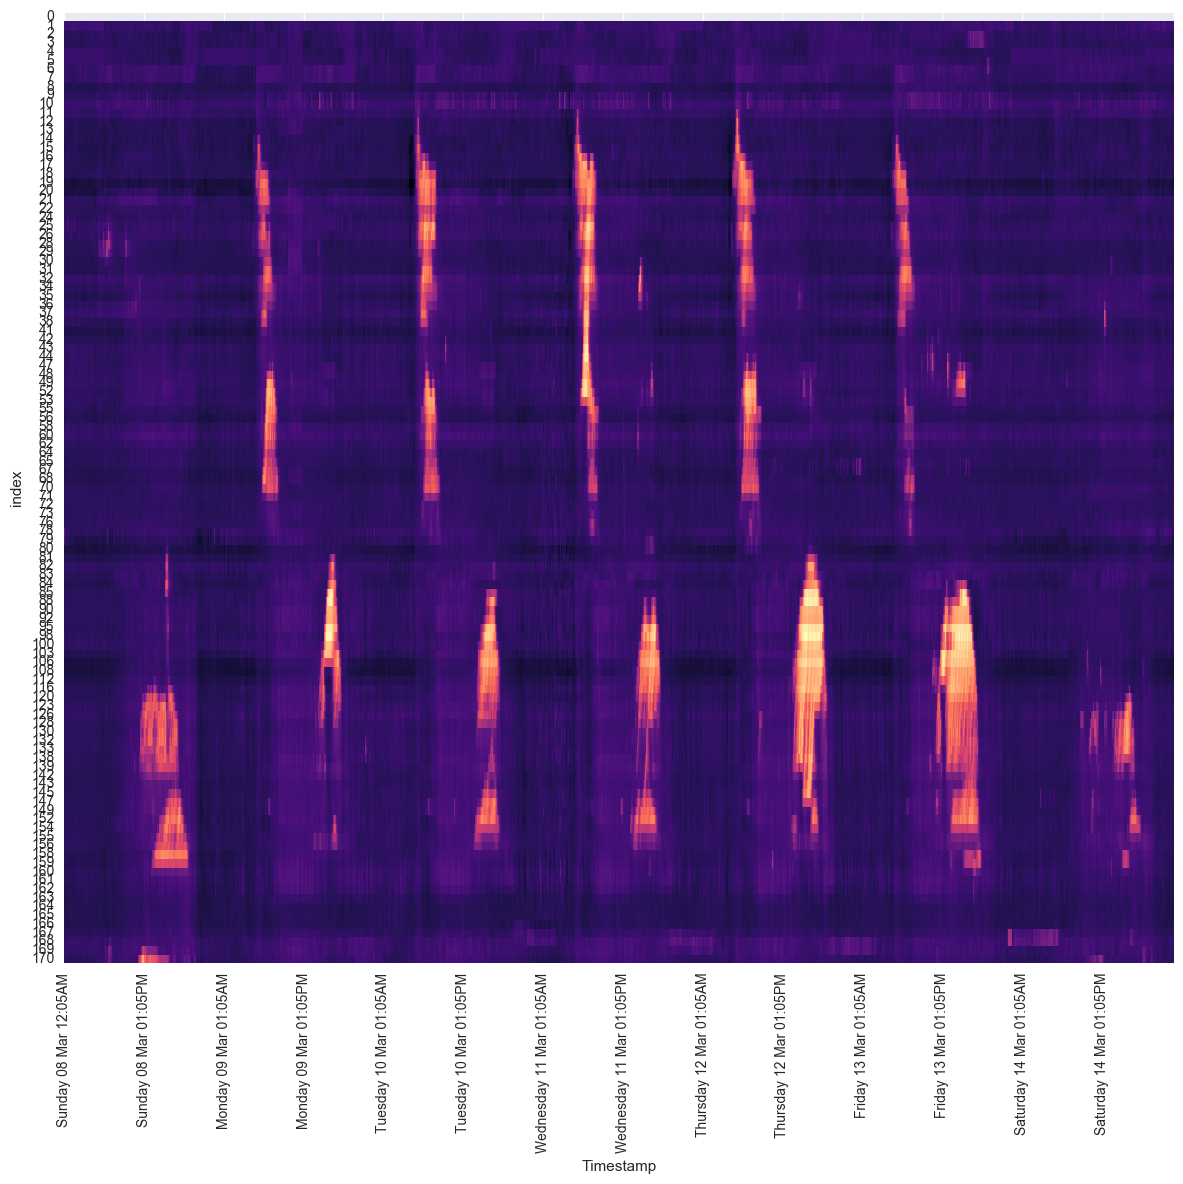

In [25]:
r = get_timeslice(df,start_date='03/08/2015', end_date='03/14/2015', on='Avg Speed')#.dropna(axis=0, how='all')
r = r.rolling(window=2,center=True).median()
plot_traffic_heat(r, cmap='magma_r')

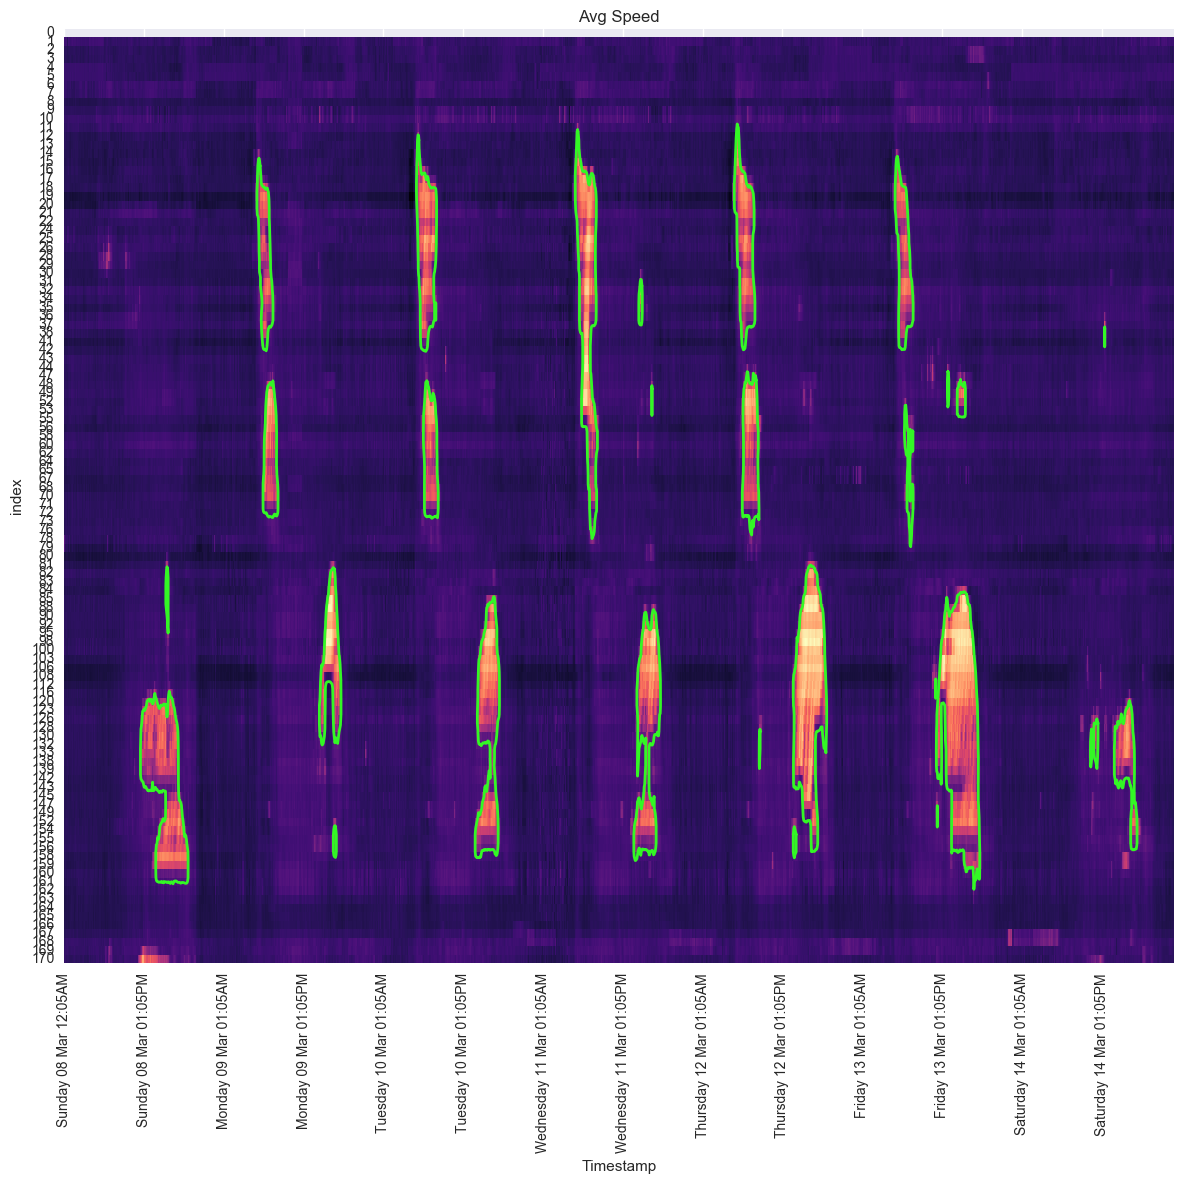

In [26]:
plot_contours(r, 55, cmap='magma_r', title="Avg Speed")